# Tookit

In [8]:
from common_all import *

In [9]:
_Data_PATH_ = './data/' # where to save the data
_Figure_PATH_ = './figures/' # where to save the figures
colors = ['C0', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#008000', '#90EE90'] # define colors

## Network Structure

In [10]:
def network(param_nx, structure = 'complete'):
    '''
    param_nx: dictionary of parameters
    structure: type of network
    '''
    if structure == 'complete': # complete graph
        G = nx.complete_graph(param_nx['N'])
    elif structure == 'lattice': # two-dimensional grid graph (square or rectangle)
        G = nx.grid_2d_graph(param_nx['L'], param_nx['H'], periodic = True) 
    elif structure == 'WS': # Watts–Strogatz small-world graph
        G = nx.watts_strogatz_graph(param_nx['N'], param_nx['k'], param_nx['b'])

    print(G.number_of_nodes(), G.number_of_edges()) # basic information
    return nx.to_numpy_array(G) # adjacency matrix

# Figure 1

In [11]:
# only health state
def result_h(A, T, param, repetition):
    '''
    A: network adjacency matrix
    T: iteration time
    repetition: times od repetition
    param: dictionary of the parameters
    '''
    t = np.linspace(0, T/A.shape[0], T+1)
    solution_S = np.zeros(T+1); solution_nq = np.zeros(T+1)
    solution_h_q = np.zeros((T+1, 4)) # S_nq, S_q, I_nq, I_q
    model = SI_model(A, T, param)
    pool = mp.Pool(int(mp.cpu_count()-2))
    results = pool.starmap(model.simulateH, [(k, ) for k in range(repetition)])
    pool.close()
    pool.join()
    for solution_S_k in results:
        solution_S += solution_S_k
    solution_S = solution_S/repetition
    solution_I = 1 - solution_S
    # save data
    data = {
        'T': list(range(T+1)),
        'S': solution_S,
        'I': solution_I
    }
    df = pd.DataFrame(data)
    current_time = datetime.datetime.now().strftime("%Y%m%d%H%M")
    df.to_csv(_Data_PATH_ + 'only health, T = ' + str(T) + ', b = ' + str(param['b']) + ', r = ' + str(param['r']) + ', repetition = ' + str(repetition) + ', ' + current_time + '.csv', index=False)
    return(solution_S.tolist(), solution_I.tolist())

In [12]:
# health state & social state
def result_h_q(A, T, param, repetition):
    '''
    A: network adjacency matrix
    T: iteration time
    repetition: times od repetition
    param: dictionary of the parameters
    '''
    t = np.linspace(0, T/A.shape[0], T+1)
    solution_S = np.zeros(T+1); solution_nq = np.zeros(T+1)
    solution_h_q = np.zeros((T+1, 4)) # S_nq, S_q, I_nq, I_q
    model = SI_model(A, T, param)
    pool = mp.Pool(int(mp.cpu_count()-2))
    results = pool.starmap(model.simulate, [(k, ) for k in range(repetition)])  # Run simulations in parallel
    pool.close()
    pool.join()
    for solution_S_k, solution_nq_k, solution_h_q_k, state_h, state_q in results:
        solution_S += solution_S_k
        solution_nq += solution_nq_k
        solution_h_q += solution_h_q_k
        state_h = state_h
        state_q = state_q
    solution_S = solution_S/repetition
    solution_I = 1 - solution_S
    solution_nq = solution_nq/repetition
    solution_q = 1 - solution_nq
    solution_h_q = solution_h_q/repetition
    health_quarantine = {
        'S_nq': solution_h_q[:,0],
        'S_q': solution_h_q[:,1],
        'I_nq': solution_h_q[:,2],
        'I_q': solution_h_q[:,3]
    }
    # save data
    data = {
        'T': list(range(T+1)),
        'S': solution_S,
        'I': solution_I,
        'nq': solution_nq,
        'q': solution_q,
        'S_nq': solution_h_q[:,0],
        'S_q': solution_h_q[:,1],
        'I_nq': solution_h_q[:,2],
        'I_q': solution_h_q[:,3],
        'state_h': state_h,
        'state_q': state_q
    }
    df = pd.DataFrame(data)
    current_time = datetime.datetime.now().strftime("%Y%m%d%H%M")
    df.to_csv(_Data_PATH_ + 'T = ' + str(T) + ', b = ' + str(param['b']) + ', r = ' + str(param['r']) + ', repetition = ' + str(repetition) + ', ' + current_time + '.csv', index=False)
    return(solution_S.tolist(), solution_I.tolist(), solution_nq.tolist(), solution_q.tolist(), solution_h_q[:,0].tolist(), solution_h_q[:,1].tolist(), solution_h_q[:,2].tolist(), solution_h_q[:,3].tolist(), state_h.tolist(), state_q.tolist())

In [38]:
N = 1000; A = network({'N': N}, structure = 'complete'); T = 2000000; repetition = 400
param = {'epsilon':0.05, 'beta': 0.12, 'gamma': 0.1, 'probability': 0.15, 'b': 0.1, 'c': 1, 'D': 10000, 'r': 0.1, 'K': 0.1}
S_h, I_h = result_h(A, T, param, repetition)
S, I, nq, q, SNQ, SQ, INQ, IQ = result_h_q(A, T, param, repetition)

100 4950


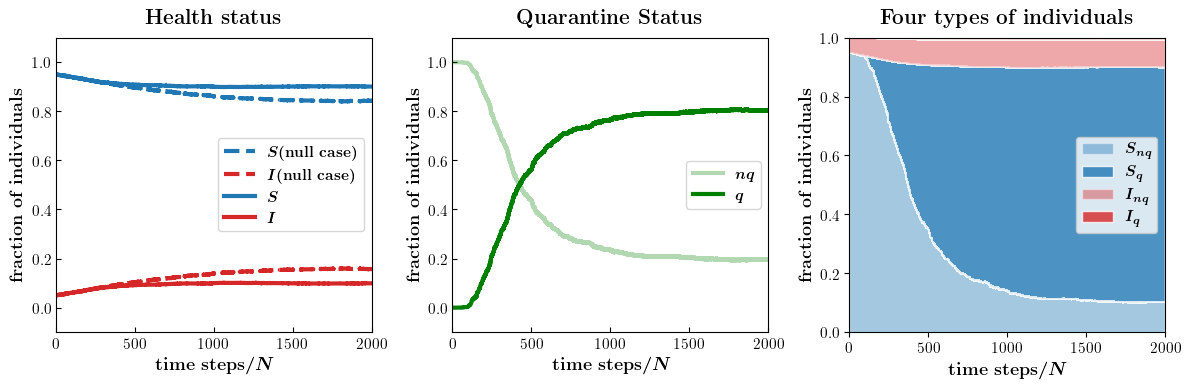

In [17]:
# figure1
fsize = (12, 4); fs = 15; t = np.linspace(0, T/N, T+1)
fig = plt.figure(figsize = fsize)
fig.patch.set_facecolor('white')
cs = {'S': colors[0], 'I': colors[3], 'nq': colors[5]}

# epidemiology
ax = plt.subplot(131)
ax.spines['left'].set_visible(True)
ax.set_xlabel(r'\textbf{time steps}' + r'$\bm{/N}$', fontsize = fs - 2)
ax.set_ylabel(r'\textbf{fraction of individuals}', fontsize = fs - 2)
ax.tick_params(axis = 'both', which = 'major', direction='in', bottom = True, left = True, labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', direction='in', bottom = True, left = True, labelsize = fs - 4)
title = r'\textbf{Health status}'
ax.set_xlim(0, T/N)
ax.set_ylim(-0.1, 1.1)
plt.plot(t, S, linestyle = 'dotted', color = colors[0], linewidth = 3, label = r'$\bm{S}$' +  r'\textbf{(null case)}')
plt.plot(t, I, linestyle = 'dotted', color = colors[3], linewidth = 3, label = r'$\bm{I}$' +  r'\textbf{(null case)}')
plt.plot(t, S_h, color = colors[0], linewidth = 3, label = r'$\bm{S}$')
plt.plot(t, I_h, color = colors[3], linewidth = 3, label = r'$\bm{I}$')
ax.legend(loc = 'center right', fancybox = True, fontsize = fs - 4)
plt.title(title, fontsize = fs, y = 1.02)

# Social State
ax = plt.subplot(132)
ax.set_xlabel(r'\textbf{time steps}' + r'$\bm{/N}$', fontsize = fs - 2)
ax.set_ylabel(r'\textbf{fraction of individuals}', fontsize = fs - 2)
ax.tick_params(axis = 'both', which = 'major', direction='in', bottom = True, left = True, labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', direction='in', bottom = True, left = True, labelsize = fs - 4)
title = r'\textbf{Quarantine Status}'
ax.set_xlim(0, T/N)
ax.set_ylim(-0.1, 1.1)
plt.plot(t, nq, color = colors[5], alpha = 0.3, linewidth = 3, label = r'$\bm{nq}$')
plt.plot(t, q, color = colors[5], alpha = 1, linewidth = 3, label = r'$\bm{q}$')
ax.legend(loc = 'center right', fancybox = True, fontsize = fs - 4)
plt.title(title, fontsize = fs, y = 1.02)

# stack plot
ax = plt.subplot(133)
ax.set_xlabel(r'\textbf{time steps}' + r'$\bm{/N}$', fontsize = fs - 2)
ax.set_ylabel(r'\textbf{fraction of individuals}', fontsize = fs - 2)
ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
title = r'\textbf{Four types of individuals}'
ax.set_xlim(0, T/N)
ax.set_ylim(0, 1)
ax.stackplot(t, SNQ, SQ, INQ, IQ, labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$'], 
             colors = [colors[0], colors[0], colors[3], colors[3]], edgecolor = 'w')
children = ax.get_children()
children[0].set_alpha(0.4)
children[1].set_alpha(0.8)
children[2].set_alpha(0.4)
children[3].set_alpha(0.8)
ax.legend(loc = 'center right', ncol = 1, fancybox = True, fontsize = fs - 4)
plt.title(title, fontsize = fs, y = 1.02)

plt.savefig(_Figure_PATH_ + 'fig1.png', dpi = 600, facecolor = fig.get_facecolor(), 
            edgecolor = 'b', bbox_inches = 'tight')

plt.show()

# Figure 2

In [ ]:
# b = 0.15
N = 1000; A = network({'N': N}, structure = 'complete'); T = 4000000; repetition = 400
param = {'epsilon':0.05, 'beta': 0.12, 'gamma': 0.1, 'probability': 0.15, 'b': 0.15, 'c': 1, 'D': 10000, 'r': 0.1, 'K': 0.1}
S, I, nq, q, SNQ, SQ, INQ, IQ = result_h_q(A, T, param, repetition)

In [ ]:
# change of b
N = 1000; A = network({'N': N}, structure = 'complete'); T = 4000000; repetition = 400
fraction_I = []; fraction_q = []
for b in np.linspace(0, 1, 10):
    param = {'epsilon':0.05, 'beta': 0.12, 'gamma': 0.1, 'probability': 0.15, 'b': b, 'c': 1, 'D': 10000, 'r': 0.01, 'K': 0.1}
    S, I, nq, q, SNQ, SQ, INQ, IQ = result_h_q(A, T, param, repetition)
    mean_SI = np.around(I[-1], decimals = 6)
    mean_qnq = np.around(q[-1], decimals = 6)
    fraction_I.append(mean_SI); fraction_q.append(mean_qnq)
print(fraction_I, fraction_q)

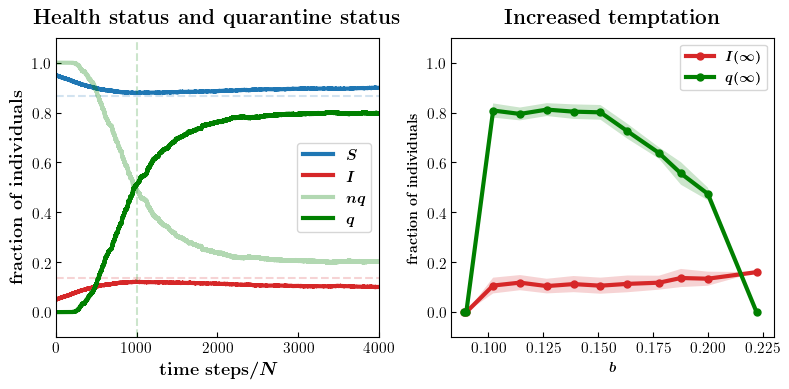

In [13]:
# figure2
fsize = (8, 4); fs = 15; t = np.linspace(0, T/N, T+1)
fig = plt.figure(figsize = fsize)
fig.patch.set_facecolor('white')

# b=0.15
ax = plt.subplot(121)
ax.spines['left'].set_visible(True)
ax.set_xlabel(r'\textbf{time steps}' + r'$\bm{/N}$', fontsize = fs - 2)
ax.set_ylabel(r'\textbf{fraction of individuals}', fontsize = fs - 2)
ax.tick_params(axis = 'both', which = 'major', direction='in', bottom = True, left = True, labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', direction='in', bottom = True, left = True, labelsize = fs - 4)
title = r'\textbf{Health status and social status}'
ax.set_xlim(0, T/N)
ax.set_ylim(-0.1, 1.1)
cs = {'S': colors[0], 'I': colors[3], 'nq': colors[5]}
plt.plot(t, S, color = colors[0], linewidth = 3, label = r'$\bm{S}$')
plt.axhline(0.865, color = colors[0], alpha = 0.2, linestyle = 'dashed')
plt.plot(t, I, color = colors[3], linewidth = 3, label = r'$\bm{I}$')
plt.axhline(0.135, color = colors[3], alpha = 0.2, linestyle = 'dashed')
plt.plot(t, nq, color = colors[5], alpha = 0.3, linewidth = 3, label = r'$\bm{nq}$')
plt.plot(t, q, color = colors[5], alpha = 1, linewidth = 3, label = r'$\bm{q}$')
plt.axvline(1000, color = colors[5], alpha = 0.2, linestyle = 'dashed')
ax.legend(loc = 'center right', fancybox = True, fontsize = fs - 4)
plt.title(title, fontsize = fs, y = 1.02)

# b值变化
ax = plt.subplot(122)
plt.rc('text', usetex = True)
ax.set_xlabel(r'$\bm{b}$')
ax.set_ylabel(r'\textbf{fraction of individuals}')
ax.tick_params(axis = 'both', which = 'major', direction='in', bottom = True, left = True, labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', direction='in', bottom = True, left = True, labelsize = fs - 4)
b = [0.08888888888888889, 0.09, 0.10222222222222221, 0.11444444444444445, 0.12666666666666668, 0.1388888888888889, 0.1511111111111111, 0.16333333333333333, 0.17777777777777778, 0.1877777777777778, 0.2, 0.22222222222222224]
fraction_I = [0, 0.0, 0.1065, 0.1182, 0.1044, 0.1124, 0.106, 0.1132, 0.118, 0.1368, 0.1339, 0.1603] #simulation results
fraction_q = [0, 0.0, 0.8082, 0.7945, 0.8119, 0.8037, 0.8009, 0.7255, 0.6379, 0.5559, 0.4742, 0]
solution = np.column_stack((fraction_I, fraction_q))
error_I = [0, 0, 0.03161632231513803, 0.030425441377130397, 0.029317317442781453, 0.032398114985442136, 0.03224127101616173, 0.03357831958420929, 0.028018016537467515, 0.0363866097945443, 0.0282744143831628, 0]
error_q = [0, 0, 0.028507099008449638, 0.025818818612744897, 0.025842060189348905, 0.029125667739583156, 0.02949695710956307, 0.030124534662837227, 0.022805293379070068, 0.045296110083013555, 0.025548569126992236, 0]
fraction_I = np.array(fraction_I); fraction_q = np.array(fraction_q)
error_I = np.array(error_I); error_q = np.array(error_q)
lower_bound_I = fraction_I - error_I; upper_bound_I = fraction_I + error_I
lower_bound_q = fraction_q - error_q; upper_bound_q = fraction_q + error_q
title = r'\textbf{Increased temptation}'
ax.set_xlim(0.083, 0.23)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([0.1, 0.125, 0.150, 0.175, 0.2, 0.225])
plt.plot(b, fraction_I, color = colors[3], marker = 'o', linewidth = 3, label = r'$\bm{I(\infty)}$', markersize = 5)
plt.plot(b, fraction_q, color = colors[5], marker = 'o', linewidth = 3, label = r'$\bm{q(\infty)}$', markersize = 5)
plt.fill_between(b, lower_bound_I, upper_bound_I, color = colors[3], alpha = 0.2, edgecolor = 'none')
plt.fill_between(b, lower_bound_q, upper_bound_q, color = colors[5], alpha = 0.2, edgecolor = 'none')
ax.legend(loc = 'upper right', fancybox = True)
plt.title(title, fontsize = fs, y = 1.02)

plt.savefig(_Figure_PATH_ + 'fig2.png', dpi = 600, facecolor = fig.get_facecolor(), 
            edgecolor = 'b', bbox_inches = 'tight')

plt.show()

# Figure 3

In [ ]:
# r = 0.2
N = 1000; A = network({'N': N}, structure = 'complete'); T = 300000; repetition = 400
param = {'epsilon':0.05, 'beta': 0.12, 'gamma': 0.1, 'probability': 0.15, 'b': 0.1, 'c': 1, 'D': 10000, 'r': 0.2, 'K': 0.1}
S, I, nq, q, SNQ, SQ, INQ, IQ = result_h_q(A, T, param, repetition)

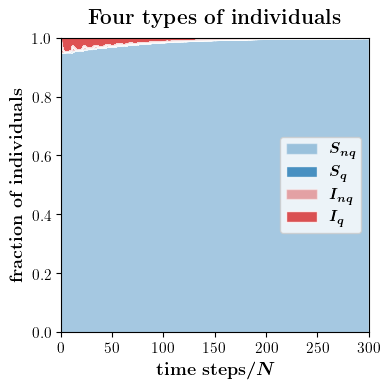

In [18]:
# figure3.1
fsize = (4, 4); fs = 15; t = np.linspace(0, T/N, T+1)
fig = plt.figure(fsize)
fig.patch.set_facecolor('white')
ax = plt.subplot(111)
ax.set_xlabel(r'\textbf{time steps}' + r'$\bm{/N}$', fontsize = fs - 2)
ax.set_ylabel(r'\textbf{fraction of individuals}', fontsize = fs - 2)
ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
title = r'\textbf{Four types of individuals}'
ax.set_xlim(0, T/N)
ax.set_ylim(0, 1)
ax.stackplot(t, SNQ, SQ, INQ, IQ, labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$'], 
             colors = [colors[0], colors[0], colors[3], colors[3]], edgecolor = 'w')
children = ax.get_children()
children[0].set_alpha(0.4)
children[1].set_alpha(0.8)
children[2].set_alpha(0.4)
children[3].set_alpha(0.8)
ax.legend(loc = 'center right', ncol = 1, fancybox = True, fontsize = fs - 4)
plt.title(title, fontsize = fs, y = 1.02)
plt.savefig(_Figure_PATH_ + 'fig31.png', dpi = 600, facecolor = fig.get_facecolor(), 
            edgecolor = 'b', bbox_inches = 'tight')
plt.show()

In [ ]:
# change of r
N = 1000; A = network({'N': N}, structure = 'complete'); T = 3000000; repetition = 400
fraction_I = []; fraction_q = []
for r in np.linspace(0.01, 0.1, 11):
    param = {'epsilon':0.05, 'beta': 0.12, 'gamma': 0.1, 'probability': 0.15, 'b': 0.1, 'c': 1, 'D': 10000, 'r': r, 'K': 0.1}
    S, I, nq, q, SNQ, SQ, INQ, IQ = result_h_q(A, T, param, repetition)
    mean_SI = np.around(I[-1], decimals = 6)
    mean_qnq = np.around(q[-1], decimals = 6)
    fraction_I.append(mean_SI); fraction_q.append(mean_qnq)
print(fraction_I, fraction_q)

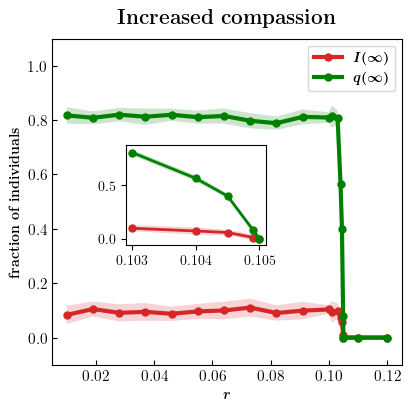

In [20]:
# figure 3.2
fsize = (4, 4); fs = 15
fig = plt.figure(figsize, constrained_layout=True)
fig.patch.set_facecolor('white')
ax = plt.subplot(111)
ax.set_xlabel(r'$\bm{r}$')
ax.set_ylabel(r'\textbf{fraction of individuals}')
ax.tick_params(axis = 'both', which = 'major', direction='in', bottom = True, left = True, labelsize = fs - 4)
ax.tick_params(axis = 'both', which = 'minor', direction='in', bottom = True, left = True, labelsize = fs - 4)
r = [0.01, 0.019, 0.028, 0.037, 0.046, 0.055, 0.064, 0.073, 0.082, 0.091, 0.1,
     0.101, 0.103, 0.104, 0.1045, 0.1049, 0.105, 0.11, 0.12]
fraction_I = [0.0835, 0.105, 0.0911, 0.0947, 0.0875, 0.0963, 0.0997, 0.1103, 0.0905, 0.0991, 0.1035,
              0.0951, 0.0979, 0.0724, 0.0578, 0.0109, 0, 0, 0]
fraction_q = [0.8175, 0.8087, 0.8201, 0.8126, 0.8198, 0.8109, 0.8154, 0.7977, 0.7888, 0.812, 0.8096, 
             0.8137, 0.8095, 0.5668, 0.4, 0.0803, 0, 0, 0]
solution = np.column_stack((fraction_I, fraction_q))
error_I = [0.033577684320895966, 0.02741265443528603, 0.031526470899022926, 0.03224422745363322, 0.026323697970268782, 0.0275149310115695, 0.03231180467086969, 0.03296571502860115, 0.02812520113306767, 0.032088627268862746, 0.01595932329392447, 0.03927467377331098, 0.029043957977806886, 0.033883921262453105, 0.025787787807409954, 0.029304869259541882, 0, 0, 0]
error_q = [0.030407325468986418, 0.02391039027881024, 0.02460314398359588, 0.030348318045045997, 0.022345349087681304, 0.024216548566833283, 0.02774317345707565, 0.02800230311227696, 0.024569302233577932, 0.027232063934311847, 0.019651971911235747, 0.04000874904317802, 0.026467849654585884, 0.027253812031902427, 0.023611649667060527, 0.024974733609001282, 0, 0, 0]
fraction_I = np.array(fraction_I); fraction_q = np.array(fraction_q)
error_I = np.array(error_I); error_q = np.array(error_q)
lower_bound_I = fraction_I - error_I; upper_bound_I = fraction_I + error_I
lower_bound_q = fraction_q - error_q; upper_bound_q = fraction_q + error_q
title = r'\textbf{Increased compassion}'
ax.set_xlim(0.005, 0.125)
ax.set_ylim(-0.1, 1.1)
plt.plot(r, fraction_I, color = colors[3], marker = 'o', linewidth = 3, label = r'$\bm{I(\infty)}$', markersize = 5)
plt.plot(r, fraction_q, color = colors[5], marker = 'o', linewidth = 3, label = r'$\bm{q(\infty)}$', markersize = 5)
plt.fill_between(r, lower_bound_I, upper_bound_I, color = colors[3], alpha = 0.2, edgecolor = 'none')
plt.fill_between(r, lower_bound_q, upper_bound_q, color = colors[5], alpha = 0.2, edgecolor = 'none')
ax.legend(loc = 'upper right', fancybox = True)
plt.title(title, fontsize = fs, y = 1.02)

r1 = [0.103, 0.104, 0.1045, 0.1049, 0.105]
fraction_I1 = [0.0979, 0.0724, 0.0578, 0.0109, 0]
fraction_q1 = [0.8095, 0.5668, 0.4, 0.0803, 0]
error_I1 = [0.029043957977806886, 0.033883921262453105, 0.025787787807409954, 0.029304869259541882, 0.01]
error_q1 = [0.026467849654585884, 0.027253812031902427, 0.023611649667060527, 0.024974733609001282, 0]
fraction_I1 = np.array(fraction_I1); fraction_q1 = np.array(fraction_q1)
error_I1 = np.array(error_I1); error_q1 = np.array(error_q1)
lower_bound_I1 = fraction_I1 - error_I1; upper_bound_I1 = fraction_I1 + error_I1
lower_bound_q1 = fraction_q1 - error_q1; upper_bound_q1 = fraction_q1 + error_q1
ax2 = fig.add_axes([0.3, 0.4, 0.35, 0.25])
ax2.tick_params(axis = 'both', which = 'major', direction='out', bottom = True, left = True)
ax2.tick_params(axis = 'both', which = 'minor', direction='out', bottom = True, left = True)
ax2.plot(r1, fraction_I1, color = colors[3], marker = 'o', linewidth = 2, markersize = 5)
ax2.plot(r1, fraction_q1, color = colors[5], marker = 'o', linewidth = 2, markersize = 5)
ax2.fill_between(r1, lower_bound_I1, upper_bound_I1, color = colors[3], alpha = 0.2, edgecolor = 'none')
ax2.fill_between(r1, lower_bound_q1, upper_bound_q1, color = colors[5], alpha = 0.2, edgecolor = 'none')

plt.savefig(_Figure_PATH_ + 'fig32.png', dpi = 600, facecolor = fig.get_facecolor(), 
            edgecolor = 'b', bbox_inches = 'tight')
plt.show()


# Figure 4

In [22]:
def map_states_to_result(state_h, state_q):
    result = []
    for x, y in zip(state_h, state_q):
        if x == 0 and y == 0:
            result.append(0)
        elif x == 0 and y == 1:
            result.append(1)
        elif x == 1 and y == 0:
            result.append(2)
        elif x == 1 and y == 1:
            result.append(3)
        else:
            result.append(-1) 

    result = np.array(result).reshape(32, 32)
    return result

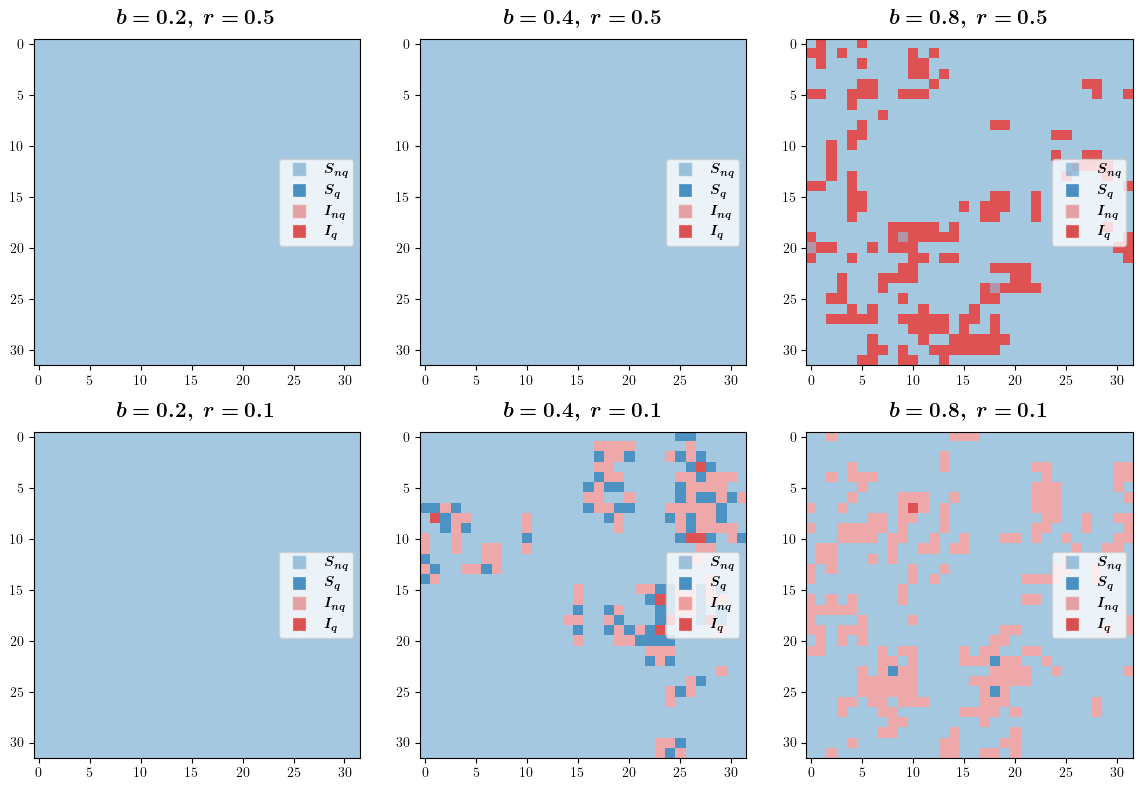

In [24]:
N = 1000; A = network({'N': N}, structure = 'complete'); fsize = (12, 8); fs = 15; repetition = 1
colors = [to_rgba('C0', 0.4), to_rgba('C0', 0.8), to_rgba('#d62728', 0.4), to_rgba('#d62728', 0.8)]
values = [0, 1, 2, 3]
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(np.linspace(0, 1, len(values)), colors)))

fig = plt.figure(figsize = fsize)
fig.patch.set_facecolor('white')

ax = plt.subplot(231)
T = 2000000
param = {'epsilon':0.05, 'beta': 0.175, 'gamma': 0.1, 'probability': 0.15, 'b': 0.2, 'c': 1, 'D': 10000, 'r': 0.5, 'K': 0.1}
*_, state_h, state_q = result_h_q(A, T, param, repetition)
result = map_states_to_result(state_h, state_q)
plt.imshow(result, cmap=custom_cmap, interpolation='nearest')
legend_labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$']
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color=to_rgba('w', 0), markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)], loc='center right')
plt.title(r'$\bm{b = 0.2,\ r = 0.5}$', fontsize = fs, y = 1.02)

ax = plt.subplot(232)
T = 2000000
param = {'epsilon':0.05, 'beta': 0.175, 'gamma': 0.1, 'probability': 0.15, 'b': 0.4, 'c': 1, 'D': 10000, 'r': 0.5, 'K': 0.1}
*_, state_h, state_q = result_h_q(A, T, param, repetition)
result = map_states_to_result(state_h, state_q)
plt.imshow(result, cmap=custom_cmap, interpolation='nearest')
legend_labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$']
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color=to_rgba('w', 0), markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)], loc='center right')
plt.title(r'$\bm{b = 0.4,\ r = 0.5}$', fontsize = fs, y = 1.02)

ax = plt.subplot(233)
T = 4000000
param = {'epsilon':0.05, 'beta': 0.175, 'gamma': 0.1, 'probability': 0.15, 'b': 0.8, 'c': 1, 'D': 10000, 'r': 0.5, 'K': 0.1}
*_, state_h, state_q = result_h_q(A, T, param, repetition)
result = map_states_to_result(state_h, state_q)
plt.imshow(result, cmap=custom_cmap, interpolation='nearest')
legend_labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$']
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color=to_rgba('w', 0), markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)], loc='center right')
plt.title(r'$\bm{b = 0.8,\ r = 0.5}$', fontsize = fs, y = 1.02)

ax = plt.subplot(234)
T = 2000000
param = {'epsilon':0.05, 'beta': 0.175, 'gamma': 0.1, 'probability': 0.15, 'b': 0.2, 'c': 1, 'D': 10000, 'r': 0.1, 'K': 0.1}
*_, state_h, state_q = result_h_q(A, T, param, repetition)
result = map_states_to_result(state_h, state_q)
plt.imshow(result, cmap=custom_cmap, interpolation='nearest')
legend_labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$']
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color=to_rgba('w', 0), markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)], loc='center right')
plt.title(r'$\bm{b=0.2,\ r=0.1}$', fontsize = fs, y = 1.02)

ax = plt.subplot(235)
T = 2000000
param = {'epsilon':0.05, 'beta': 0.175, 'gamma': 0.1, 'probability': 0.15, 'b': 0.4, 'c': 1, 'D': 10000, 'r': 0.1, 'K': 0.1}
*_, state_h, state_q = result_h_q(A, T, param, repetition)
result = map_states_to_result(state_h, state_q)
plt.imshow(result, cmap=custom_cmap, interpolation='nearest')
legend_labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$']
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color=to_rgba('w', 0), markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)], loc='center right')
plt.title(r'$\bm{b = 0.4,\ r = 0.1}$', fontsize = fs, y = 1.02)

ax = plt.subplot(236)
T = 5000000
param = {'epsilon':0.05, 'beta': 0.175, 'gamma': 0.1, 'probability': 0.15, 'b': 0.8, 'c': 1, 'D': 10000, 'r': 0.1, 'K': 0.1}
*_, state_h, state_q = result_h_q(A, T, param, repetition)
result = map_states_to_result(state_h, state_q)
plt.imshow(result, cmap=custom_cmap, interpolation='nearest')
legend_labels = [r'$\bm{S_{nq}}$', r'$\bm{S_q}$', r'$\bm{I_{nq}}$', r'$\bm{I_q}$']
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color=to_rgba('w', 0), markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)], loc='center right')
plt.title(r'$\bm{b = 0.8,\ r = 0.1}$', fontsize = fs, y = 1.02)

plt.savefig(_Figure_PATH_ + 'lattice_fig3.png', dpi = 600, facecolor = fig.get_facecolor(), 
            edgecolor = 'b', bbox_inches = 'tight')
plt.show()